
# Functional → Anatomy → HCR Mapping (Zebrafish, 2P + HCR)

This notebook automates a practical pipeline to map motion-corrected functional planes to the best matching **2P anatomy** Z-plane and then into **HCR/confocal** space.

**Core steps**
1. Build a *crisp* per-plane functional reference using a Suite2p-style **top‑correlated mean**.
2. For each plane, find the **best matching Z** in the 2P anatomy stack via **normalized cross‑correlation**.
3. Estimate an **in‑plane transform** (shift/similarity) from functional reference → anatomy[best‑Z].
4. Apply a precomputed **3D warp** (anatomy → HCR) to place the functional plane/slab into HCR space.
5. Transfer **ROI labels** (nearest‑neighbor) or **fluorescence images** (linear) as appropriate.

> Tip: Set the voxel sizes (µm) correctly for both stacks before registration, and keep a record of transforms so you can compose and resample **once** wherever possible.



## Requirements

This notebook uses common scientific Python packages:

- `numpy`, `scipy`, `pandas`
- `tifffile`
- `scikit-image` (`skimage`)
- `opencv-python` (optional; speeds up template matching)
- `matplotlib` for quick QA plots

If an import fails, install the package in your environment and re-run the cell.


In [24]:

import os, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from tifffile import imread, imwrite, TiffFile
from skimage import filters, exposure, transform, feature, measure, registration, img_as_float32
from skimage.transform import SimilarityTransform, AffineTransform, warp
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi

# Optional OpenCV (accelerated NCC); guarded import
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

import matplotlib.pyplot as plt

print("HAS_CV2:", HAS_CV2)


HAS_CV2: True



## Paths & I/O

Edit these to your data. You can also point to your colleague's helper notebook (`/mnt/data/fToA_registration_jl.ipynb`) if you want to copy functions from it.


In [25]:

# --- User paths (EDIT ME) ---
INPUT_DIR = Path('/Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/input')
OUTDIR = Path('/Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/output'); OUTDIR.mkdir(exist_ok=True, parents=True)

# Default input files inside INPUT_DIR
FUNC_STACK_PATH = INPUT_DIR / 'L395_f11_plane0_mcorrected_flipX_substack.tif'   # motion-corrected, single plane over time OR volume over time
ANAT_STACK_PATH = INPUT_DIR / 'L395_f11_anatomy_2P_GCaMP.tif'   # 2P anatomy (structural) stack
# HCR_STACK_PATH  = INPUT_DIR / 'hcr_stack.tif'          # HCR/confocal stack (already cleared sample)

# Optional label image to map (e.g., Cellpose labels)
LABELS_PATH = None   # e.g., INPUT_DIR / 'cellpose_labels.tif' (uint16 IDs)

# Cellpose/segmentation masks (functional 2D, anatomy 3D)
FUNC_LABELS_PATH = INPUT_DIR / 'func_labels.png'   # per-pixel int IDs (0=bg)
ANAT_LABELS_PATH = INPUT_DIR / 'anat_labels.tif'   # 3D labels stack (Z,Y,X)

# Voxel sizes are inferred from image metadata and cached (see next cell).

# Random seed for reproducibility in frame subsampling
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)



## Utility functions


In [26]:

def zproject_mean(stack):
    return stack.mean(axis=0)

def norm01(img):
    img = img.astype(np.float32)
    m, M = np.percentile(img, (1, 99))
    if M <= m:
        M = img.max(); m = img.min()
    out = np.clip((img - m) / (M - m + 1e-6), 0, 1)
    return out

def local_unsharp(img, blur_sigma=1.0, amount=0.6):
    base = ndi.gaussian_filter(img, blur_sigma)
    return np.clip(base + amount*(img - base), 0, 1)

def corrcoef_img(a, b):
    # Pearson correlation between 2D arrays
    a = a.astype(np.float32); b = b.astype(np.float32)
    am = a.mean(); bm = b.mean()
    num = ((a - am)*(b - bm)).sum()
    den = np.sqrt(((a - am)**2).sum() * ((b - bm)**2).sum()) + 1e-8
    return float(num / den)

def top_correlated_mean(stack_t, take_k=20, pre_smooth_sigma=0.5):
    """Suite2p-like: build crisp reference by selecting top-K frames most correlated to a provisional mean."""
    T, H, W = stack_t.shape
    # Provisional mean
    m0 = stack_t.mean(axis=0)
    # Optional pre-smoothing to reduce shot noise
    if pre_smooth_sigma and pre_smooth_sigma > 0:
        m0s = ndi.gaussian_filter(m0, pre_smooth_sigma)
    else:
        m0s = m0
    # Correlate each frame with provisional mean
    corrs = np.empty(T, dtype=np.float32)
    for i in range(T):
        fi = stack_t[i]
        if pre_smooth_sigma and pre_smooth_sigma > 0:
            fi = ndi.gaussian_filter(fi, pre_smooth_sigma)
        corrs[i] = corrcoef_img(fi, m0s)
    # Take top-K
    k = min(take_k, T)
    idx = np.argsort(corrs)[-k:]
    ref = stack_t[idx].mean(axis=0)
    return ref, idx, corrs

def best_z_by_ncc(template, anat_stack, use_cv2=True):
    """Return best Z index and NCC scores over Z for a 2D template vs 3D stack."""
    template = norm01(template)
    H, W = template.shape
    scores = []
    if use_cv2 and HAS_CV2:
        templ = (template*255).astype(np.uint8)
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            sl8 = (sl*255).astype(np.uint8)
            res = cv2.matchTemplate(sl8, templ, cv2.TM_CCORR_NORMED)
            # Whole-image match: template same size; if not, pad template or crop; here we assume same FOV/size
            if res.size == 1:
                s = float(res.ravel()[0])
            else:
                s = float(res.max())
            scores.append(s)
    else:
        # fallback: simple correlation on same-size images
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            s = corrcoef_img(template, sl)
            scores.append(s)
    scores = np.asarray(scores, dtype=np.float32)
    best_z = int(np.argmax(scores))
    return best_z, scores

def estimate_inplane_transform(mov, ref, method='similarity'):
    """Estimate 2D transform from moving image (mov) to reference (ref).
    Tries ORB+RANSAC; falls back to phase cross-correlation (shift only)."""
    m = norm01(mov); r = norm01(ref)
    # ORB keypoints
    try:
        detector = feature.ORB(n_keypoints=2000, fast_threshold=0.05)
        detector.detect_and_extract(img_as_float32(m))
        kp1 = detector.keypoints; d1 = detector.descriptors
        detector.detect_and_extract(img_as_float32(r))
        kp2 = detector.keypoints; d2 = detector.descriptors
        if len(kp1) >= 10 and len(kp2) >= 10 and d1 is not None and d2 is not None:
            matches12 = feature.match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
            src = kp1[matches12[:, 0]][:, ::-1]  # (x,y)
            dst = kp2[matches12[:, 1]][:, ::-1]
            if method == 'similarity':
                model, inliers = measure.ransac((src, dst), SimilarityTransform,
                                                min_samples=3, residual_threshold=2.0, max_trials=2000)
            else:
                model, inliers = measure.ransac((src, dst), AffineTransform,
                                                min_samples=3, residual_threshold=2.0, max_trials=2000)
            if model is not None:
                return model
    except Exception as e:
        pass
    # Fallback: phase correlation for shift
    shift, _, _ = registration.phase_cross_correlation(r, m, upsample_factor=10)
    tform = SimilarityTransform(translation=(shift[1], shift[0]))
    return tform

def apply_transform_2d(img, tform, output_shape=None, order=1, preserve_range=True):
    if output_shape is None:
        output_shape = img.shape
    warped = warp(img, inverse_map=tform.inverse, output_shape=output_shape, order=order,
                  preserve_range=preserve_range, mode='constant', cval=0.0, clip=True)
    return warped

def resample_labels_nn(img, tform, output_shape=None):
    # nearest-neighbor for label images
    return apply_transform_2d(img, tform, output_shape=output_shape, order=0, preserve_range=True)

def apply_anat_to_hcr_warp_2d(slice_img, z_index, warp3d_func):
    """Hook to apply a 3D warp (anatomy→HCR) to a 2D slice.
    `warp3d_func` should accept (z,y,x) indices or coordinates and return warped image in HCR coords.
    For now this is a placeholder you can implement with your BigWarp/ANTs output.
    """
    return warp3d_func(slice_img, z_index)

def quickshow(img, title='', vmin=None, vmax=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img, vmin=vmin, vmax=vmax)
    plt.title(title); plt.axis('off'); plt.show()



## 1) Build a crisp functional reference per plane

If your functional input is **single-plane over time**: this outputs one reference.  
If it's **volume over time**: set `PLANE_INDEX` to the plane you want, or loop planes.


Functional shape: (1000, 512, 512)
Saved reference to /Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/output/func_ref_plane0.tif


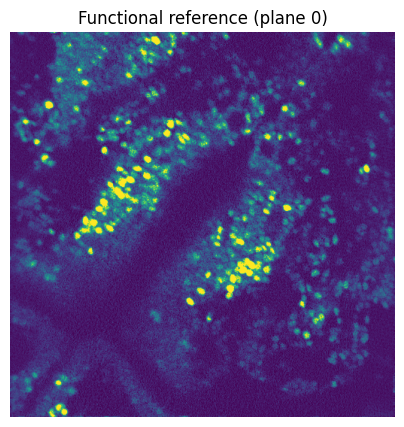

In [27]:

# Load functional data
func = imread(FUNC_STACK_PATH)
print("Functional shape:", func.shape)

# Detect dimensionality: (T, Y, X) or (T, Z, Y, X)
if func.ndim == 3:
    # Single plane over time
    T, H, W = func.shape
    ref2d, kept_idx, corrs = top_correlated_mean(func, take_k=min(20, T), pre_smooth_sigma=0.5)
    ref2d = norm01(ref2d)
    imwrite(OUTDIR/'func_ref_plane0.tif', (ref2d*65535).astype(np.uint16))
    print(f"Saved reference to {OUTDIR/'func_ref_plane0.tif'}")
    quickshow(ref2d, "Functional reference (plane 0)")
else:
    # Volume over time
    T, Z, H, W = func.shape
    PLANE_INDEX = 0  # EDIT: choose plane
    plane_t = func[:, PLANE_INDEX, :, :]
    ref2d, kept_idx, corrs = top_correlated_mean(plane_t, take_k=min(20, T), pre_smooth_sigma=0.5)
    ref2d = norm01(ref2d)
    imwrite(OUTDIR/f'func_ref_plane{PLANE_INDEX}.tif', (ref2d*65535).astype(np.uint16))
    print(f"Saved reference to {OUTDIR/f'func_ref_plane{PLANE_INDEX}.tif'}")
    quickshow(ref2d, f"Functional reference (plane {PLANE_INDEX})")



## 2) Find the best matching Z in the 2P anatomy stack
We correlate the functional reference against each anatomy slice and take the Z with the maximum NCC.


Anatomy shape: (216, 750, 750)
Best Z in anatomy: 124


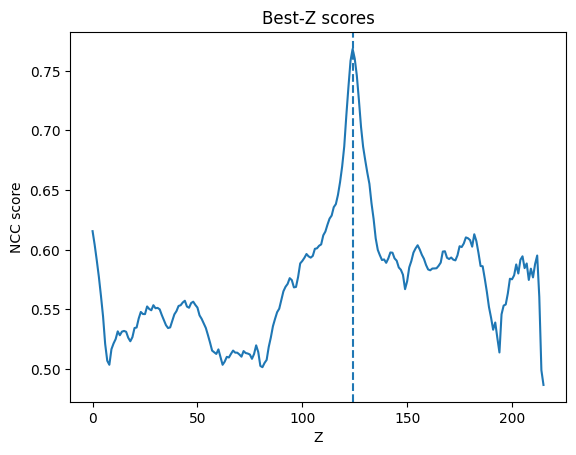

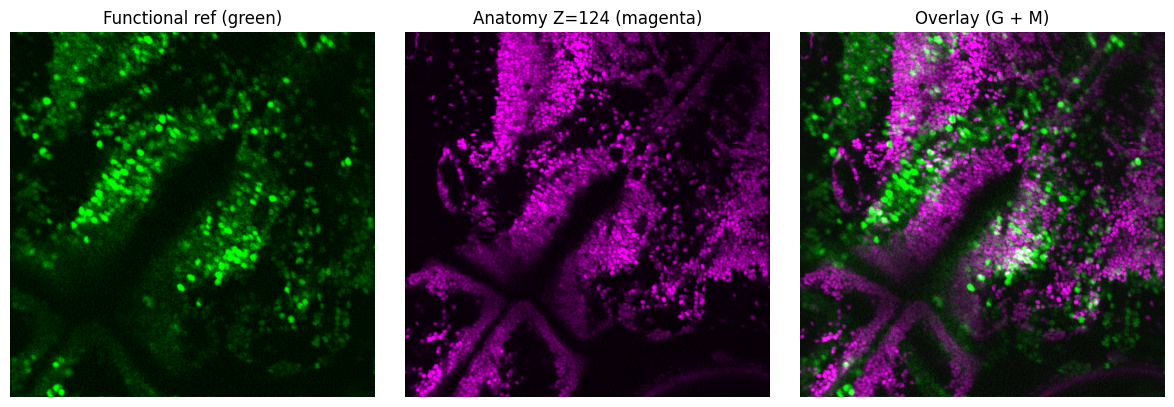

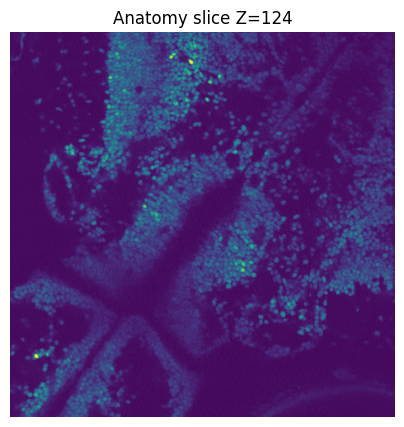

In [28]:

anat = imread(ANAT_STACK_PATH)
print("Anatomy shape:", anat.shape)

# Optional pre-filter to enhance structure
anat_f = np.stack([local_unsharp(norm01(s), 1.0, 0.6) for s in anat], axis=0)
ref_f  = local_unsharp(norm01(ref2d), 1.0, 0.6)

best_z, scores = best_z_by_ncc(ref_f, anat_f, use_cv2=True)
print("Best Z in anatomy:", best_z)

# Save scores for QA
pd.Series(scores).to_csv(OUTDIR/'bestZ_scores.csv', index=False)

plt.figure()
plt.plot(scores); plt.axvline(best_z, linestyle='--')
plt.xlabel('Z'); plt.ylabel('NCC score'); plt.title('Best-Z scores')
plt.show()

# Sanity check: visualize functional ref (green) vs anatomy best-Z (magenta)
f_vis = norm01(ref2d)
a_vis = norm01(anat[best_z])
# Harmonize shapes for overlay — resize functional to anatomy slice shape if needed
if f_vis.shape != a_vis.shape:
    try:
        f_vis = transform.resize(f_vis, a_vis.shape, order=1, mode='reflect',
                                 preserve_range=True, anti_aliasing=True).astype(np.float32)
    except Exception as _e:
        # Fallback: center-crop both to common min size
        th, tw = min(f_vis.shape[0], a_vis.shape[0]), min(f_vis.shape[1], a_vis.shape[1])
        def _cc(img, th, tw):
            h, w = img.shape; y0 = max(0, (h-th)//2); x0 = max(0, (w-tw)//2); return img[y0:y0+th, x0:x0+tw]
        f_vis = _cc(f_vis, th, tw); a_vis = _cc(a_vis, th, tw)
func_rgb = np.stack([np.zeros_like(f_vis), f_vis, np.zeros_like(f_vis)], axis=-1)
anat_rgb = np.stack([a_vis, np.zeros_like(a_vis), a_vis], axis=-1)
overlay = np.clip(func_rgb + anat_rgb, 0, 1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(func_rgb); plt.title('Functional ref (green)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(anat_rgb); plt.title(f'Anatomy Z={best_z} (magenta)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(overlay); plt.title('Overlay (G + M)'); plt.axis('off')
plt.tight_layout(); plt.show()

quickshow(anat[best_z], f'Anatomy slice Z={best_z}')



## 3) Estimate in-plane transform (functional → anatomy[best‑Z])
We try ORB+RANSAC to get a **similarity** (shift/scale/rotation) transform, and fall back to phase correlation (shift only).


Estimated transform: [[ 1.04011611e+00 -7.04649677e-03  1.24384082e+02]
 [ 7.04649677e-03  1.04011611e+00  1.27418227e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


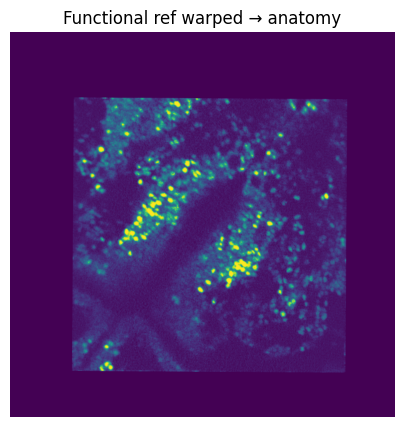

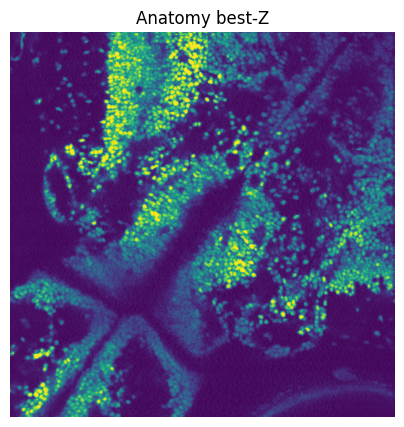

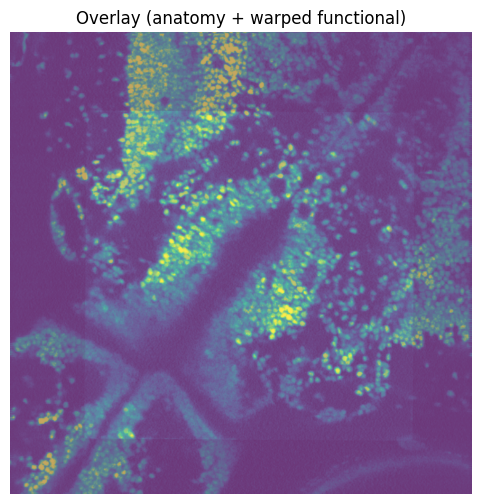

Saved transform to /Users/ddharmap/dataProcessing/2p_HCR/analysis/2pf-2pa/output/func_to_anat_similarity_2x3.npy


In [29]:

tform = estimate_inplane_transform(ref_f, anat_f[best_z], method='similarity')
print("Estimated transform:", tform.params)

# Warp the functional reference into anatomy space for visual QA
ref_warped = apply_transform_2d(ref_f, tform, output_shape=anat_f[best_z].shape, order=1)
quickshow(ref_warped, 'Functional ref warped → anatomy')
quickshow(anat_f[best_z], 'Anatomy best-Z')

# Overlay QA
plt.figure(figsize=(6,6))
plt.imshow(anat_f[best_z], alpha=0.7)
plt.imshow(ref_warped, alpha=0.3)
plt.title('Overlay (anatomy + warped functional)')
plt.axis('off'); plt.show()

# Save transform matrix
np.save(OUTDIR/'func_to_anat_similarity_2x3.npy', tform.params)
print("Saved transform to", OUTDIR/'func_to_anat_similarity_2x3.npy')


In [30]:

# Interactive overlay: toggle channels like FIJI
try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_WIDGETS = True
except Exception as _e:
    _HAS_WIDGETS = False
    print('ipywidgets not available; skipping interactive overlay. Install ipywidgets to enable.')

# Prepare normalized views (may depend on earlier cells)
__overlay_ready = True
try:
    # Prefer warped functional reference if available; else compute a preview using the current transform; else fall back.
    if 'ref_warped' in globals() and ref_warped is not None:
        f_src = ref_warped; F_SRC_LABEL = 'warped'
    elif 'tform' in globals():
        mov_src = ref_f if 'ref_f' in globals() else ref2d
        f_src = apply_transform_2d(mov_src, tform, output_shape=anat[best_z].shape, order=1); F_SRC_LABEL = 'tform-preview'
    else:
        f_src = ref2d; F_SRC_LABEL = 'raw'
    f_vis = norm01(f_src)
    a_vis = norm01(anat[best_z])
    # Harmonize shapes for overlay — resize functional to anatomy slice shape if needed
    if f_vis.shape != a_vis.shape:
        f_vis = transform.resize(f_vis, a_vis.shape, order=1, mode='reflect', preserve_range=True, anti_aliasing=True).astype(np.float32)
except Exception as _e:
    print('Interactive overlay prerequisites missing (ref2d/anat/best_z). Run previous cells first.)')
    __overlay_ready = False

# Define simple LUTs
_COLORS = {
    'green':   (0.0, 1.0, 0.0),
    'magenta': (1.0, 0.0, 1.0),
    'red':     (1.0, 0.0, 0.0),
    'blue':    (0.0, 0.0, 1.0),
    'cyan':    (0.0, 1.0, 1.0),
    'yellow':  (1.0, 1.0, 0.0),
    'white':   (1.0, 1.0, 1.0)
}

def _apply_color(gray01, rgb):
    r, g, b = rgb
    return np.stack([gray01*r, gray01*g, gray01*b], axis=-1)

def _render(show_func=True, show_anat=True, func_color='green', anat_color='magenta', func_alpha=1.0, anat_alpha=1.0):
    out = np.zeros((f_vis.shape[0], f_vis.shape[1], 3), dtype=np.float32)
    if show_anat:
        out += _apply_color(a_vis, _COLORS[anat_color]) * float(anat_alpha)
    if show_func:
        out += _apply_color(f_vis, _COLORS[func_color]) * float(func_alpha)
    out = np.clip(out, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(out)
    plt.title(f'Overlay — func[{func_color}] alpha={func_alpha:.2f}, anat[{anat_color}] alpha={anat_alpha:.2f} | func src: {F_SRC_LABEL}')
    plt.axis('off')
    plt.show()

show_func_cb = widgets.Checkbox(value=True, description='Show functional')
show_anat_cb = widgets.Checkbox(value=True, description='Show anatomy')
func_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='green', description='Func LUT')
anat_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='magenta', description='Anat LUT')
func_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Func α')
anat_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Anat α')

if _HAS_WIDGETS and __overlay_ready:
    ui = widgets.VBox([
        widgets.HBox([show_func_cb, func_color_dd, func_alpha_sl]),
        widgets.HBox([show_anat_cb, anat_color_dd, anat_alpha_sl])
    ])
    out = widgets.interactive_output(_render, {
        'show_func': show_func_cb,
        'show_anat': show_anat_cb,
        'func_color': func_color_dd,
        'anat_color': anat_color_dd,
        'func_alpha': func_alpha_sl,
        'anat_alpha': anat_alpha_sl,
    })
    display(ui, out)
elif _HAS_WIDGETS and not __overlay_ready:
    print('Interactive overlay not shown: run best-Z cell first.')


Output()


## 3.1) Functional → Anatomy label centroids + matching
Compute ROIs centroids for functional labels and anatomy labels (best‑Z slice), warp functional to anatomy with nearest‑neighbor to keep IDs intact, and link labels by nearest centroid (Hungarian).


In [31]:

from scipy.optimize import linear_sum_assignment

def _ensure_uint_labels(arr):
    arr = np.asarray(arr)
    if not np.issubdtype(arr.dtype, np.integer):
        arr = arr.astype(np.int64)
    return arr

def _regionprops_centroids_2d(label_img):
    # Returns DataFrame with columns: label, cy, cx
    tbl = measure.regionprops_table(label_img, properties=['label', 'centroid'])
    df = pd.DataFrame(tbl).rename(columns={'centroid-0': 'cy', 'centroid-1': 'cx'})
    df = df[df['label'] != 0].reset_index(drop=True)
    return df

def _apply_tform_points_xy(tform, x, y):
    # tform expects (x,y) pairs
    pts = np.stack([x, y], axis=1)
    pts_t = tform(pts)
    return pts_t[:,0], pts_t[:,1]

# Load labels if available
func_labels = None
anat_labels = None
if FUNC_LABELS_PATH and os.path.exists(FUNC_LABELS_PATH):
    func_labels = _ensure_uint_labels(imread(FUNC_LABELS_PATH))
    if func_labels.ndim == 3:
        # If saved as RGB PNG, take a channel or decode; assume single channel
        func_labels = func_labels[...,0]
if ANAT_LABELS_PATH and os.path.exists(ANAT_LABELS_PATH):
    anat_labels = _ensure_uint_labels(imread(ANAT_LABELS_PATH))

if func_labels is None or anat_labels is None:
    print('Skipping centroid matching: missing FUNC_LABELS_PATH or ANAT_LABELS_PATH.')
else:
    # Ensure functional labels same size as functional reference
    if 'ref2d' in globals() and func_labels.shape != ref2d.shape:
        func_labels = transform.resize(func_labels, ref2d.shape, order=0, preserve_range=True, anti_aliasing=False).astype(func_labels.dtype)

    # Take anatomy labels slice at best_z if 3D
    if anat_labels.ndim == 3:
        anat_labels_z = anat_labels[int(best_z)]
    else:
        anat_labels_z = anat_labels

    # Warp functional labels to anatomy slice using nearest-neighbor to keep IDs
    if 'tform' not in globals():
        raise RuntimeError('Transform tform not available; run the in-plane transform cell first.')
    func_labels_warp = resample_labels_nn(func_labels, tform, output_shape=anat_labels_z.shape)
    func_labels_warp = _ensure_uint_labels(func_labels_warp)
    imwrite(OUTDIR/'func_labels_in_anat_slice.tif', func_labels_warp.astype(np.uint16))

    # Centroids in functional, transformed as points (more stable than raster warp for centers)
    fdf = _regionprops_centroids_2d(func_labels)
    tx, ty = _apply_tform_points_xy(tform, fdf['cx'].values, fdf['cy'].values)
    fdf['cx_t'] = tx; fdf['cy_t'] = ty

    # Centroids in anatomy (best-Z slice)
    adf = _regionprops_centroids_2d(anat_labels_z)

    # Build cost matrix and match with Hungarian
    if len(fdf) == 0 or len(adf) == 0:
        print('No labels to match (empty functional or anatomy labels).')
    else:
        F = fdf[['cx_t','cy_t']].to_numpy()
        A = adf[['cx','cy']].to_numpy()
        # Compute pairwise distances
        d2 = ((F[:,None,:] - A[None,:,:])**2).sum(axis=2)
        D = np.sqrt(d2)
        row_ind, col_ind = linear_sum_assignment(D)
        # Optional distance gate (pixels)
        MAX_LINK_DIST_PX = 50.0
        keep = D[row_ind, col_ind] <= MAX_LINK_DIST_PX
        row_ind = row_ind[keep]; col_ind = col_ind[keep]

        links = []
        for r, c in zip(row_ind, col_ind):
            fxp, fyp = float(F[r,0]), float(F[r,1])
            axp, ayp = float(A[c,0]), float(A[c,1])
            dist_px = float(D[r,c])
            # micron distances using VOX_ANAT (y=1, x=2)
            dx_um = (fxp - axp) * float(VOX_ANAT[2])
            dy_um = (fyp - ayp) * float(VOX_ANAT[1])
            dist_um = float(np.sqrt(dx_um*dx_um + dy_um*dy_um))
            links.append({
                'f_label': int(fdf.loc[r,'label']),
                'a_label': int(adf.loc[c,'label']),
                'fx_anat_px': fxp, 'fy_anat_px': fyp,
                'ax_px': axp, 'ay_px': ayp,
                'dist_px': dist_px, 'dist_um': dist_um
            })
        links_df = pd.DataFrame(links)
        if len(links_df):
            links_df.to_csv(OUTDIR/'f2a_centroid_matches.csv', index=False)
            print('Saved matches →', OUTDIR/'f2a_centroid_matches.csv')
        else:
            print('No matches within distance threshold.')

        # Quick 2D QC plot on best-Z
        plt.figure(figsize=(6,6))
        plt.imshow(norm01(anat[int(best_z)]), cmap='gray')
        if len(links_df):
            plt.scatter(links_df['ax_px'], links_df['ay_px'], s=30, c='magenta', label='Anat centroids')
            plt.scatter(links_df['fx_anat_px'], links_df['fy_anat_px'], s=30, facecolors='none', edgecolors='lime', label='Func→Anat centroids')
            for _, row in links_df.iterrows():
                plt.plot([row['ax_px'], row['fx_anat_px']], [row['ay_px'], row['fy_anat_px']], 'y-', alpha=0.5)
            plt.legend(loc='lower right')
        plt.title('Centroid matches on anatomy best-Z')
        plt.axis('off'); plt.show()


Skipping centroid matching: missing FUNC_LABELS_PATH or ANAT_LABELS_PATH.



## 3.2) 3D viewer for anatomy with overlays
Scroll Z, toggle overlays (anatomy labels, warped functional labels, and centroids).


In [32]:

try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_W = True
except Exception:
    _HAS_W = False
    print('ipywidgets not available; skipping 3D viewer.')

if _HAS_W and 'anat' in globals():
    Z = anat.shape[0] if anat.ndim == 3 else 1
    z_sl = widgets.IntSlider(value=int(best_z) if 'best_z' in globals() else 0, min=0, max=max(0,Z-1), step=1, description='Z')
    show_anat_lbl = widgets.Checkbox(value=True, description='Show anatomy labels')
    show_func_lbl = widgets.Checkbox(value=os.path.exists(OUTDIR/'func_labels_in_anat_slice.tif'), description='Show func labels (warped)')
    show_centroids = widgets.Checkbox(value=True, description='Show centroids')
    alpha_lbl = widgets.FloatSlider(value=0.4, min=0.0, max=1.0, step=0.05, description='Label α')

    # Load for viewer (lazy)
    _anat_labels = None
    if ANAT_LABELS_PATH and os.path.exists(ANAT_LABELS_PATH):
        _anat_labels = _ensure_uint_labels(imread(ANAT_LABELS_PATH))
    _func_warp = None
    fw_path = OUTDIR/'func_labels_in_anat_slice.tif'
    if os.path.exists(fw_path):
        _func_warp = _ensure_uint_labels(imread(fw_path))

    def _draw(z, show_al, show_fl, show_pts, alpha):
        sl = anat[z] if anat.ndim == 3 else anat
        plt.figure(figsize=(6,6))
        plt.imshow(norm01(sl), cmap='gray')
        if show_al and _anat_labels is not None:
            if _anat_labels.ndim == 3:
                al = _anat_labels[z]
            else:
                al = _anat_labels
            plt.imshow(al, cmap='nipy_spectral', alpha=alpha, interpolation='nearest')
        if show_fl and _func_warp is not None and z == int(best_z):
            plt.imshow(_func_warp, cmap='viridis', alpha=alpha, interpolation='nearest')
        if show_pts and os.path.exists(OUTDIR/'f2a_centroid_matches.csv') and z == int(best_z):
            df = pd.read_csv(OUTDIR/'f2a_centroid_matches.csv')
            if len(df):
                plt.scatter(df['ax_px'], df['ay_px'], s=25, c='magenta', label='Anat c')
                plt.scatter(df['fx_anat_px'], df['fy_anat_px'], s=25, facecolors='none', edgecolors='lime', label='Func→Anat c')
        plt.title(f'Anatomy Z={z}')
        plt.axis('off'); plt.show()

    out = widgets.interactive_output(_draw, {
        'z': z_sl, 'show_al': show_anat_lbl, 'show_fl': show_func_lbl, 'show_pts': show_centroids, 'alpha': alpha_lbl
    })
    ui = widgets.VBox([z_sl, widgets.HBox([show_anat_lbl, show_func_lbl, show_centroids, alpha_lbl])])
    display(ui, out)
else:
    print('3D viewer prerequisites missing (anat, ipywidgets).')


Output()


## 4) (Optional) Transfer ROI labels safely (nearest-neighbor)

If you have a label image (e.g., Cellpose IDs), warp it with **order=0** (nearest‑neighbor) to avoid fragmentation or mixing of labels.


In [ ]:

if LABELS_PATH and os.path.exists(LABELS_PATH):
    labels = imread(LABELS_PATH)
    if labels.ndim == 2:
        labels_warp = resample_labels_nn(labels, tform, output_shape=anat.shape[1:])
        imwrite(OUTDIR/'labels_in_anat_space.tif', labels_warp.astype(np.uint16))
        print("Saved labels_in_anat_space.tif")
        quickshow(labels_warp>0, 'Labels (any>0) in anatomy space')
    else:
        print("LABELS_PATH is not a 2D label image; adapt code for your layout.")
else:
    print("No LABELS_PATH provided; skipping labels transfer.")



## 5) Apply anatomy → HCR 3D warp (hook)

Provide a function `warp3d_func(slice_img, z_index)` that applies your 3D deformation field to a 2D slice at Z.  
This is where you plug in BigWarp/ANTs/SimpleITK. Below is a **mock** that passes data through unchanged.


In [ ]:

def dummy_warp3d(slice_img, z_index):
    # Replace with your BigWarp/ANTs application. This is identity.
    return slice_img

# Example usage:
slice_in_hcr = apply_anat_to_hcr_warp_2d(ref_warped, best_z, warp3d_func=dummy_warp3d)
quickshow(slice_in_hcr, 'Slice in HCR space (dummy)')



## 6) Save a small JSON with parameters and results


In [ ]:

meta = {
    "FUNC_STACK_PATH": FUNC_STACK_PATH,
    "ANAT_STACK_PATH": ANAT_STACK_PATH,
    "HCR_STACK_PATH": HCR_STACK_PATH,
    "best_z": int(best_z),
    "transform_params_2x3": tform.params.tolist(),
    "voxels": {"func": VOX_FUNC, "anat": VOX_ANAT, "hcr": VOX_HCR},
    "rng_seed": RNG_SEED,
}

with open(OUTDIR/'run_metadata.json', 'w') as f:
    json.dump(meta, f, indent=2)

print("Wrote", OUTDIR/'run_metadata.json')



## Notes & next steps

- If the NCC best‑Z curve is **broad** or has multiple peaks, consider matching a **slab** (±2–3 slices) instead of a single slice.
- For in‑plane alignment, try `method='affine'` if you suspect slight shear/scale differences.
- To register **anatomy → HCR** in Python, consider:
  - **SimpleITK (Elastix)**: rigid→affine→B‑spline with mutual information.
  - **ANTsPy**: SyN-based deformable registration.
- Once you have a 3D transform, apply it to **grayscale** with linear order, to **labels** with nearest‑neighbor.
- Compose transforms and resample once if you can (functional → anatomy → HCR → output).